In [1]:
import pandas as pd
from scipy import special, integrate
import numpy as np
from yahoo_fin import options
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

In [2]:
plt.style.use('fivethirtyeight')

In [16]:
def CharFunc(u, params, type, dt):

    if type == 1: # Gaussian distribution
        mu, sigma = params[0], params[1]
        return np.exp(dt*(1j * u * mu - 0.5 * (sigma**2) * (u**2)))
    elif type == 2: # Variance Gamma distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt) * (1 - 1j * u * theta * kappa + 0.5 * (u**2) * (sigma**2) * kappa) ** (-dt / kappa)
    elif type == 3: # Normal inverse Gaussian distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt + dt/kappa * (1 - np.sqrt(1 + (u**2) * (sigma**2) * kappa - 2 * 1j * u * theta * kappa)))
    elif type == 4: # CGMY distribution
        mu, C, G, M, Y = params[0], params[1], params[2], params[3], params[4]
        return np.exp(1j * u * mu * dt + C * special.gamma(-Y) * dt * ((M - 1j * u) ** Y - (M**Y) + (G + 1j * u) ** Y - (G**Y)))
    elif type == 5: # Merton Jump Diffusion
        mu, sigma, l, mu_z, sigma_z = params[0], params[1], params[2], params[3], params[4]
        phi_Y = np.exp(1j * u * mu_z - 0.5 * (sigma_z**2) * (u**2))
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 6: # Kou Jump Diffusion
        mu, sigma, l, p, eta1, eta2 = params[0], params[1], params[2], params[3], params[4], params[5]
        q = 1 - p
        phi_Y = p * eta1/(eta1 * 1j * u) + q * eta2/(eta2 * 1j * u)
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 7: # Heston
        mu, sigma, k, neta, theta, rho = params[0], params[1], params[2], params[3], params[4], params[5]
        d = ((rho * theta * u * 1j - k)**2 - (theta**2) * (-1j * u - (u**2))) ** 0.5
        rep = k - rho * theta * u * 1j - d
        g = rep/(rep + 2 * d)
        tmp1 = np.exp(1j * u * mu * dt)
        tmp2 = np.exp(neta * k * (theta**-2) * (rep * dt - 2 * np.log((1 - g * np.exp(-d * dt))/(1 - g))))
        tmp3 = np.exp(sigma * (theta**-2) * rep * (1 - np.exp(-d * dt))/(1 - g * np.exp(-d * dt)))
        return tmp1 * tmp2 * tmp3

In [4]:
def call_option_transform(u, K, R):
    return (K ** (1 - R - 1j * u))/((1 - R - 1j * u) * (- R - 1j * u))

In [80]:
tick = 'AAPL'
exp_date = options.get_expiration_dates(tick)[0]
calls = pd.DataFrame()
calls = options.get_calls(tick)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       47 non-null     object 
 1   Last Trade Date     47 non-null     object 
 2   Strike              47 non-null     float64
 3   Last Price          47 non-null     float64
 4   Bid                 47 non-null     float64
 5   Ask                 47 non-null     float64
 6   Change              47 non-null     float64
 7   % Change            47 non-null     object 
 8   Volume              47 non-null     object 
 9   Open Interest       47 non-null     int64  
 10  Implied Volatility  47 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 4.2+ KB


In [81]:
calls['Implied Volatility'] = calls['Implied Volatility'].str.replace('%', '').astype(float)/100
calls = calls.drop(['Contract Name', 'Last Trade Date', 'Last Price', 'Ask', 'Change', '% Change', 'Volume', 'Open Interest'], axis=1)

In [82]:
def BlackScholesCall(S,K,r,T,sigma):
    d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    BSCall = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return BSCall

In [83]:
stock = yf.Ticker(tick)
price = stock.history(period='1d')
S = price['Close'][0]
r = 0.05
T = (datetime.strptime(exp_date, '%B %d, %Y') - datetime.today()).days/366
for i in range(calls.shape[0]):
    calls.loc[i, 'Calculated Price'] = BlackScholesCall(S, calls.loc[i, 'Strike'], r, T, calls.loc[i, 'Implied Volatility'])

calls['Price delta'] = calls['Bid'] - calls['Calculated Price']
calls

,Strike,Bid,Implied Volatility,Calculated Price,Price delta
0,95.0,86.30,3.1016,8.628574e+01,1.426341e-02
1,100.0,81.30,2.7109,8.128631e+01,1.368612e-02
2,110.0,71.55,2.9316,7.129081e+01,2.591886e-01
3,115.0,66.30,2.3125,6.628865e+01,1.134973e-02
4,120.0,61.30,2.1172,6.128937e+01,1.063460e-02
5,125.0,56.30,1.9727,5.629027e+01,9.734561e-03
6,130.0,51.20,1.7070,5.129067e+01,-9.067269e-02
7,135.0,46.15,1.4922,4.629127e+01,-1.412652e-01
8,140.0,41.20,1.3711,4.129216e+01,-9.215666e-02
9,145.0,36.25,1.2070,3.629291e+01,-4.291317e-02


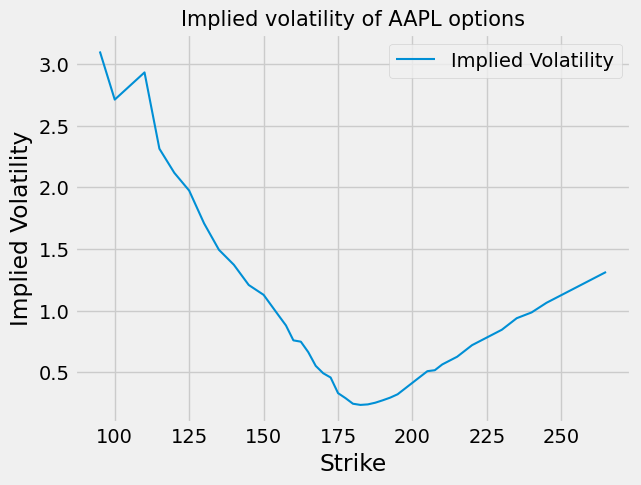

In [84]:
calls.plot('Strike', 'Implied Volatility', linewidth=1.5)
plt.title(f'Implied volatility of {tick} options', fontsize=15)
plt.ylabel('Implied Volatility')
plt.show()

In [101]:
def fourier_pricing(type, params, K, S, r, T):
    R = 1.1
    s = -np.log(S)
    q = 0
    if type == 7:
        omega = 0
    else:
        omega = np.log(CharFunc(-1j, params, type, T))

    mu = r - q - omega
    params[0] = mu

    c_mod = pd.Series()
    for i in range(calls.shape[0]):
        c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) * 
                                                                                        CharFunc(u - 1j * R, params, type, T) * 
                                                                                        call_option_transform(u, K.iloc[i], R)).real, 
                                                                                        0, np.inf)[0]
    return c_mod

In [103]:
type = 3
theta = -0.3
sigma = 0.20
kappa = 0.03
init_guess = [theta, sigma, kappa]
mu = 0
params = [mu, theta, sigma, kappa]

K = calls['Strike'].astype(int)
res = minimize(((calls['Bid'] - fourier_pricing(type, params, K, S, r, T))**2).sum(), x0=init_guess, method='Nelder-Mead')

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_33213/2176318434.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) *


TypeError: 'numpy.float64' object is not callable